# Dynamic Thresh Algorithm V2 

### Details:
> - Use **ST Baseline** and **LT Sigma** as the basic **Parameters**   
> - Fomula:

$$ baseline_{st} = \frac{1}{m}\sum_{i=0}^{m}data_{st}(i) $$
$$ \sigma_{lt} = \frac{1}{m}\sum_{i=0}^{m}(data_{lt}(i)-\mu_{lt}) $$

$$ upper\_thresh = baseline_{st} + k * \sigma_{lt} $$
$$ upper\_thresh = baseline_{st} - k * \sigma_{lt} $$
> $k$ is the **Hyperparameters** to be calculated by **Cross Validation**

### New Features in V2
> - All data will be **Normalized**
$$ normalized\_data = \frac{data - data.mean(axis=1)}{data.std(axis=1)}$$
> - Always save the **base_data** (for calculating baseline, so it must keep postive) in a file, defalut is five days
> - Use the trained model to choose the recent **positive** data, and update the base_data
> - Model is trained by **Gaussian Naive Bayes**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_utils import *

# Load data

Load base data and sigma

In [2]:
rps_base_data = np.load('rps_base_data.npy')
cpu_base_data = np.load('cpu_base_data.npy')
sigma_rps = np.load('sigma_rps.npy')
sigma_cpu = np.load('sigma_cpu.npy')

Load test data and normalize

In [3]:
rps_data_test = normalize_load('rps_data_test.csv')
cpu_data_test = normalize_load('cpu_data_test.csv')

Load original test data

In [4]:
rps_data_test_real, rps_data_test_real_ndarray = load_csv_data('rps_data_test.csv')
cpu_data_test_real, cpu_data_test_real_ndarray = load_csv_data('cpu_data_test.csv')

Assume today is **2017-10-16**, load the last weekday **real** data and calculate **mu & sigma**

In [5]:
rps_mu = rps_data_test_real.loc['2017-10-13': '2017-10-13'].mean().values
rps_sigma = rps_data_test_real.loc['2017-10-13': '2017-10-13'].std().values
cpu_mu = cpu_data_test_real.loc['2017-10-13': '2017-10-13'].mean().values
cpu_sigma = cpu_data_test_real.loc['2017-10-13': '2017-10-13'].std().values

Extract today's data

In [6]:
# normalized data
rps_data_test_today = rps_data_test[-1]
cpu_data_test_today = cpu_data_test[-1]
# real data
rps_data_test_today_real = rps_data_test_real_ndarray[-1]
cpu_data_test_today_real = cpu_data_test_real_ndarray[-1]

Calculate baseline, upper_thresh and lower_thresh

In [7]:
k = 0.02

baseline_rps = rps_base_data.mean(axis=0)
upper_thresh_rps= baseline_rps + k * sigma_rps
lower_thresh_rps= baseline_rps - k * sigma_rps

# counter normalization
baseline_rps = baseline_rps * rps_sigma + rps_mu
upper_thresh_rps = upper_thresh_rps * rps_sigma + rps_mu
lower_thresh_rps = lower_thresh_rps * rps_sigma + rps_mu

In [8]:
k = 3

baseline_cpu = cpu_base_data.mean(axis=0)
upper_thresh_cpu = baseline_cpu + k * sigma_cpu
lower_thresh_cpu = baseline_cpu - k * sigma_cpu

# counter normalization
baseline_cpu = baseline_cpu * cpu_sigma + cpu_mu
upper_thresh_cpu = upper_thresh_cpu * cpu_sigma + cpu_mu
lower_thresh_cpu = lower_thresh_cpu * cpu_sigma + cpu_mu

# Show The Baseline and Upper & Lower Thresh

## RPS

In [9]:
idx_rps = np.where(np.any((rps_data_test_today_real.reshape(rps_data_test_today_real.size,-1) > upper_thresh_rps.reshape(upper_thresh_rps.size, -1), rps_data_test_today_real.reshape(rps_data_test_today_real.size, -1)< lower_thresh_rps.reshape(lower_thresh_rps.size, -1)), axis=0))
idx_rps[0].shape

(0,)

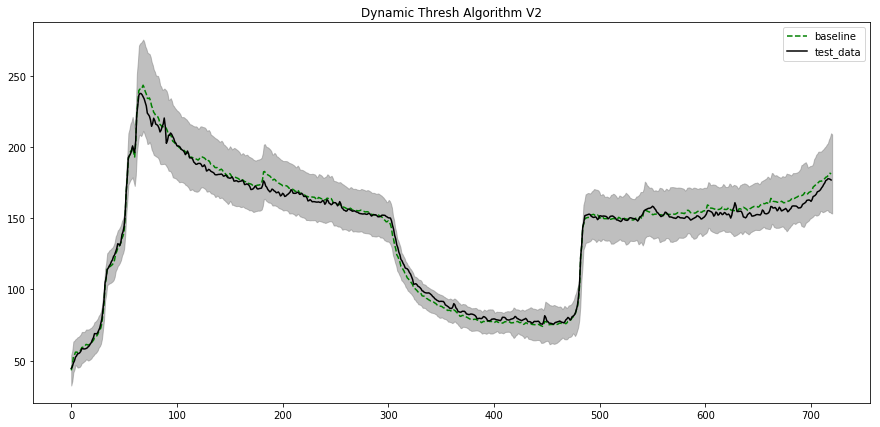

In [10]:
t = np.linspace(0, 720, 720)
plt.figure(figsize=(15, 7))
plt.plot(baseline_rps, 'g', label="baseline", ls='--')
# plt.plot(upper_thresh_rps, 'r', label='upper_thresh')
# plt.plot(lower_thresh_rps, 'r', label='lower_thresh')
plt.fill_between(t, lower_thresh_rps, upper_thresh_rps, color=(0.5, 0.5, 0.5, 0.5))
plt.plot(rps_data_test_today_real, 'k', label='test_data')
plt.plot(idx_rps[0], rps_data_test_today_real[idx_rps[0]], 'ro')
plt.legend()
plt.title('Dynamic Thresh Algorithm V2')
plt.savefig('Dynamic Thresh Algorithm V2.png', dpi=200)
plt.show()

## CPU

In [11]:
idx_cpu = np.where(np.any((cpu_data_test_today_real.reshape(cpu_data_test_today_real.size,-1) > upper_thresh_cpu.reshape(upper_thresh_cpu.size, -1), cpu_data_test_today_real.reshape(cpu_data_test_today_real.size, -1)< lower_thresh_cpu.reshape(lower_thresh_cpu.size, -1)), axis=0))
idx_cpu[0].shape

(3,)

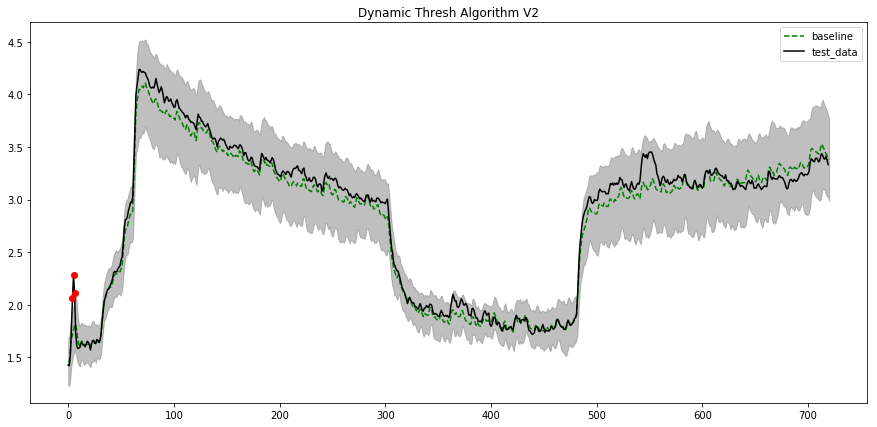

In [12]:
t = np.linspace(0, 720, 720)
plt.figure(figsize=(15, 7))
plt.plot(baseline_cpu, 'g', label="baseline", ls='--')
# plt.plot(upper_thresh_rps, 'r', label='upper_thresh')
# plt.plot(lower_thresh_rps, 'r', label='lower_thresh')
plt.fill_between(t, lower_thresh_cpu, upper_thresh_cpu, color=(0.5, 0.5, 0.5, 0.5))
plt.plot(cpu_data_test_today_real, 'k', label='test_data')
plt.plot(idx_cpu[0], cpu_data_test_today_real[idx_cpu[0]], 'ro')
plt.legend()
plt.title('Dynamic Thresh Algorithm V2')
# plt.savefig('Dynamic Thresh Algorithm V2.png', dpi=200)
plt.show()

# Update base data

In [13]:
rps_model = load_model('rps_gnb_model.pkl')
cpu_model = load_model('cpu_gnb_model.pkl')

/home/jly/anaconda2/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator GaussianNB from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
rps_base_data_new = update_base_data(rps_data_test_today, rps_base_data, rps_model)
cpu_base_data_new = update_base_data(cpu_data_test_today, cpu_base_data, cpu_model)

In [15]:
## Save the new base data to cover the older one
# np.save('rps_base_data.npy', rps_base_data_new)
# np.save('cpu_base_data.npy', cpu_base_data_new)